# Train Forecast Model - Daily
Model:
* Multilayer Perceptron (MLP) (Feedforward neural network)
* 3 layers: input, hidden, output
* Binary Classification
* `Input`: Close, SMA(2 to 16), ROC(2 to 16)
* `Output`: Does a long or short trade hit the profit target (2%) without hitting a stop loss (1.5%) in the next five days?

This script is a data pre-processing strategy for generating a machine learning dataset for an algorithmic trading model, rather than being a trading strategy itself. Its primary goal is to create labeled historical data that a machine learning model can learn from to predict future price movements (specifically, whether a long or short trade would be profitable).

Here's a breakdown of the process:

Data Loading and Indicator Calculation:
It loads historical price data (with dt, close, etc.) from a CSV file.
It calculates multiple Simple Moving Averages (SMAs) and Rates of Change (ROCs) with varying time period values (determined by repeatCount and repeatStep). These technical indicators will serve as features for the ML model.

Feature Engineering and Normalization:
For each historical data point, it constructs an "input record" that includes:
* The current closing price.
* The calculated SMA values.
* The calculated ROC values.
* A crucial step is the normalization of the close price and SMA values. They are scaled to a range between 0 and 1, which is common practice for neural networks and other ML models to improve training stability and performance. ROC values are appended directly.

Labeling (Target Variable Creation): This is the core of preparing the data for ML.
For each data point, it looks forwardWindow days into the future (e.g., 5 days).
It then checks two conditions to assign labels:
* "Long" Label (1 or 0): A "long" label is assigned if, within the forwardWindow, the price reaches a profitTarget (e.g., 2% above the current close) AND it does not hit a stopTarget (e.g., 1.5% below the current close) first. This indicates a potential profitable long trade.
* "Short" Label (1 or 0): A "short" label is assigned if, within the forwardWindow, the price reaches a profitTarget (e.g., 2% below the current close) AND it does not hit a stopTarget (e.g., 1.5% above the current close) first. This indicates a potential profitable short trade.
The lCount and sCount variables track how many instances of profitable long and short opportunities are found.

Dataset Export:
All the generated features (normalized close, SMAs, ROCs) and the corresponding "long" and "short" labels are assembled into a new Pandas DataFrame. Then we use 40% of the data to train the model. The remaining 60% are used for the validation and backtesting
In essence, this script is a feature engineering and labeling pipeline designed to create a supervised learning dataset from raw historical price data and technical indicators. The goal is to train an ML model to predict whether a "long" or "short" condition (as defined by the profit and stop targets) will be met in a future window, enabling the model to generate trading signals.

In [1]:
%run ../2_Strategies/init_model.py 'model_long_short_predict'

model_long_short_predict


In [2]:
%%writefile local/{model_name}/input/config/hyperparameters.json
{ 
}

Overwriting local/model_long_short_predict/input/config/hyperparameters.json


# Step 1) Get Data from Athena and S3

To prepare the data we read using Athena (and SQL, rather than reading from a bucket as an object), deploy dependencies locally on the Notebook instance, indexes by date and splits the data into a training and validation datasets.

In [3]:
# get S3 bucket
s3bucket=!(aws s3 ls | grep algotrading- | awk  '{print $3}')
s3bucket=s3bucket[0]
s3bucket

'algotrading-demo-616431823260'

In [4]:
import sys
!{sys.executable} -m pip install PyAthena
!{sys.executable} -m pip install --upgrade numexpr

In [5]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()
region = sess.boto_session.region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [6]:
import pandas as pd
from sqlalchemy import create_engine
from pyathena import connect
connection_string = 'awsathena+rest://@'+region+'?s3_staging_dir=s3://'+s3bucket+'/results/'
engine = create_engine(connection_string)
df_ohlcv_INTC = pd.read_sql("SELECT dt,open,high,low,close,volume FROM algo_data.hist_ohlcv_daily_alphavantage \
                WHERE dt >= DATE '2022-01-01' AND dt < DATE '2025-01-01' ORDER BY dt;", engine)
df_ohlcv_INTC.set_index(pd.DatetimeIndex(df_ohlcv_INTC['dt']),inplace=True)
del df_ohlcv_INTC['dt']
df_ohlcv_INTC.to_csv('local/'+model_name+'/input/data/training/data_orig.csv')
print("count=%s" % len(df_ohlcv_INTC))
df_ohlcv_INTC.head()

count=753


,open,high,low,close,volume
dt,,,,,
2022-01-03,51.650,53.230,51.600,53.21,33892932.0
2022-01-04,53.570,53.935,52.650,53.14,45681384.0
2022-01-05,54.188,56.170,53.830,53.87,59109324.0
2022-01-06,54.610,54.670,53.415,54.01,35757881.0
2022-01-07,54.190,54.390,53.150,53.44,30717218.0


<Axes: xlabel='dt'>

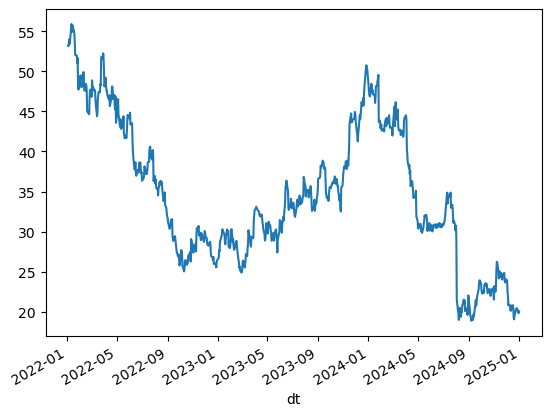

In [7]:
%matplotlib inline
df_ohlcv_INTC["close"].plot()

# Step 2) Run Data Preparation Locally

## Modify Data Preparation Code

In the following cell, you can modify the data preparation code or leave it as is. This code takes raw  time series data, calculates multiple Simple Moving Averages (SMAs) and Rate of Change (ROCs) with varying lookback periods, normalizes some of the indicator data (close price and SMAs), and then generates binary "long" and "short" labels based on whether the price in a future window meets specific profit targets while staying within stop-loss limits. The resulting processed data is then saved to a new CSV file, ready for use in a machine learning model to predict these "long" or "short" trading opportunities.

In [8]:
%%writefile model/{model_name}_prep.py
#!/usr/bin/env python
# This line is a 'shebang', telling the system to execute the script using the python interpreter.

import numpy as np 
import pandas as pd
import talib as ta  # Import TA-Lib (Technical Analysis Library) for financial indicators.
from talib.abstract import * # Import all functions from talib.abstract directly for easier use (e.g., SMA, ROC).
import math

prefix = '/opt/ml/'
input_path = prefix + 'input/data/training'

data_orig_file = input_path + '/data_orig.csv'
data_file = input_path + '/data.csv'

# --- Load Original Data ---
# Read the original CSV file into a Pandas DataFrame.
d = pd.read_csv(data_orig_file, parse_dates=['dt'], index_col=['dt'])
print(d.head()) # Print the first few rows of the loaded DataFrame for inspection.

# --- Define Parameters for Indicator Calculation and Signal Generation ---
repeatCount = 15  # How many different periods of SMA and ROC indicators will be calculated.
repeatStep = 1    # The increment for the periods of the indicators (e.g., period 2, then 3, then 4...).
lookBack = repeatCount * repeatStep # Calculates a 'look back' period, related to max indicator period.
forwardWindow = 5 # IMPORTANT - the number of future data points to look at when determining "long" and "short" signals.
                  # This defines the future window for profit/stop-loss checks.

profitTarget = 2.0 / 100.0 # Desired profit percentage (2%) as a decimal to trigger a "long" or "short" signal.
stopTarget = 1.5 / 100.0   # Maximum acceptable loss percentage (1.5%) as a decimal before a signal is invalidated.

iCount = lookBack # A counter initialized to lookBack (not explicitly used as a loop condition later, but set).
                  # Its purpose is usually to skip initial rows where technical indicators might not have enough data to be calculated.

hData = ["dt"]
hData.append("close")

# Add column names for the Simple Moving Average (SMA) indicators.
# Periods are (a+2)*repeatStep, e.g., for repeatStep=1, periods are 2, 3, 4, ..., 16.
for a in range(0, repeatCount):
    hData.append("sma" + str((a + 2) * repeatStep))

# Add column names for the Rate of Change (ROC) indicators.
# Periods are (a+2)*repeatStep, e.g., for repeatStep=1, periods are 2, 3, 4, ..., 16.
for a in range(0, repeatCount):
    hData.append("roc" + str((a + 2) * repeatStep))

hData.append("long")  # Add column for the 'long' binary signal (0 or 1).
hData.append("short") # Add column for the 'short' binary signal (0 or 1).

# --- Initialize List to Store Processed Data Rows ---
tData = [] # This list will accumulate all the rows for the new DataFrame.

# --- Prepare Input for TA-Lib Calculations ---
# TA-Lib functions typically expect NumPy arrays as input.
inputs = {
    'close': np.array(d["close"]) # Extract the 'close' column as a NumPy array.
}

# --- Calculate SMA (Simple Moving Average) Indicators ---
sma = [] 
# This is where talib is used - to calculate technical indicators.
for a in range(0, repeatCount):
    # Calculate SMA for periods (a+1)*repeatStep+1 (e.g., 2, 3, ..., 16 if repeatStep=1)
    sma.append(SMA(inputs, timeperiod=(a + 1) * repeatStep + 1))

# --- Calculate ROC (Rate of Change) Indicators ---
roc = [] 
for a in range(0, repeatCount):
    # Calculate ROC for periods (a+1)*repeatStep+1
    roc.append(ROC(inputs, timeperiod=(a + 1) * repeatStep + 1))

# --- Prepare for Iteration and Counters ---
closeList = d["close"] # Get the 'close' column as a Pandas Series for easy access to future prices.
dLen = len(d)          # Get the total number of rows in the original DataFrame.
n = 0                  # Row counter for iterating through the DataFrame.
lCount = 0             # Counter for 'long' signals generated.
sCount = 0             # Counter for 'short' signals generated.
nCount = 0             # Unused counter.
n = 0                  # Resetting 'n' (redundant if declared right before the loop).

# --- Main Loop: Process Each Row of Data ---
# Iterate through each row (index and row data) of the original DataFrame.
for idx, row in d.iterrows():
    # Ensure there are enough future data points (defined by forwardWindow)
    # to calculate the long/short signals without going out of bounds.
    if n < dLen - forwardWindow - 1:
        dt1 = idx          # Current row's datetime.
        cl = row["close"]  # Current row's closing price.
        inputRec = []      # List to store the features for the current row of the output DataFrame.
        inputRec.append(idx) # Add the datetime to the output record.

        inputRec0 = [] # Temporary list to hold the current close price and SMA values for normalization.

        # --- Add Current Close Price to Temporary List ---
        inputRec0.append(cl)

        # --- Process SMA Values ---
        for a in range(0, repeatCount):
            # If an SMA value is NaN (Not a Number, usually at the beginning of the series because
            # there isn't enough historical data to calculate the indicator),
            # it appends the current closing price instead as a fallback.
            if math.isnan(sma[a][n]):
                inputRec0.append(cl)
            else:
                inputRec0.append(sma[a][n]) # Otherwise, append the calculated SMA value.

        # --- Min-Max Normalization for Close Price and SMA Values ---
        # Scale these values to be between 0 and 1. This is a common preprocessing step for ML models.
        m1 = min(inputRec0) # Find the minimum value in the temporary list.
        m2 = max(inputRec0) # Find the maximum value in the temporary list.
        for val in inputRec0:
            if m2 - m1 == 0: # If min and max are the same (e.g., all values are identical), avoid division by zero.
                inputRec.append(0) # Append 0 in this case.
            else:
                # Apply the Min-Max Normalization formula: (value - min) / (max - min)
                inputRec.append((val - m1) / (m2 - m1))

        # --- Process ROC Values ---
        # Note: ROC values are not normalized in this section, unlike SMA/close.
        for a in range(0, repeatCount):
            if math.isnan(roc[a][n]): # Check if the ROC value is NaN.
                inputRec.append(0)    # If NaN, append 0 as a fallback.
            else:
                inputRec.append(roc[a][n]) # Otherwise, append the calculated ROC value.

        # --- Analyze Future Prices for Signal Generation ---
        # Gets a list of future closing prices within the 'forwardWindow' (e.g., next 5 days).
        # 'min(dLen-1, n+1+forwardWindow)' prevents going out of bounds at the end of the data.
        rClose = closeList[n + 1:min(dLen - 1, n + 1 + forwardWindow)].values.tolist()
        low = min(rClose)  # Find the minimum price in the future window.
        high = max(rClose) # Find the maximum price in the future window.

        # --- Determine 'Long' Signal ---
        long = 0 # Initialize 'long' signal to 0 (no signal).
        # This is the core logic for a "long" signal:
        # Condition 1: Future high must reach or exceed current close + profit target.
        # Condition 2: Future low must stay above or equal to current close - stop target (prevent significant drops).
        if high >= cl + cl * profitTarget and low >= cl - cl * stopTarget:
            long = 1 # Set 'long' signal to 1.
            lCount = lCount + 1 # Increment the 'long' signal counter.
        inputRec.append(long) # Add the 'long' signal to the current row's features.

        # --- Determine 'Short' Signal ---
        short = 0 # Initialize 'short' signal to 0 (no signal).
        # This is the core logic for a "short" signal:
        # Condition 1: Future low must reach or go below current close - profit target.
        # Condition 2: Future high must stay below or equal to current close + stop target (prevent significant rises).
        if low <= cl - cl * profitTarget and high <= cl + cl * stopTarget:
            short = 1 # Set 'short' signal to 1.
            sCount = sCount + 1 # Increment the 'short' signal counter.
        inputRec.append(short) # Add the 'short' signal to the current row's features.

        tData.append(inputRec) # Add the complete processed row to the list of all data.
        n = n + 1 # Move to the next row.

# Print the total counts of 'long' and 'short' signals generated.
print("lCount=%s,sCount=%s" % (lCount, sCount))

df1 = pd.DataFrame(tData, columns=hData)
df1.set_index(pd.DatetimeIndex(df1['dt']), inplace=True)
del df1['dt'] 

df1.to_csv(data_file)
print(df1.head()) 
print("count=%s" % (len(df1)))

Overwriting model/model_long_short_predict_prep.py


## Run Data Preparation Locally in a Docker Container

In [9]:
!cp model/{model_name}_prep.py model/train
!chmod 777 model/train
!docker build -t {model_name}_prep .
!docker run -v $(pwd)/local/$model_name:/opt/ml --rm {model_name}_prep train

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (2/3)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.12kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:nightly-  0.1s
[+] Building 0.2s (10/10)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.12kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:nightly-  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 93B                                           0.0s
 => [1/6] FROM docker.io/tensorflow/tensorflow:nightly-jupyter@sha256:be0  0.0s
 => [internal] load build context       

[+] Building 0.9s (13/22)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.44kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:latest    0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [ 1/18] FROM docker.io/tensorflow/tensorflow:latest@sha256:f24e8494d4  0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 2.92kB                                        0.0s
 => CACHED [ 2/18] RUN apt-get -y update && apt-get install -y --no-insta  0.0s
 => CACHED [ 3/18] RUN wget https://sourceforge.net/projects/ta-lib/files  0.0s
 => CACHED [ 4/18] WORKDIR /tmp                                            0.0s
 => CACHED [ 5/18] RUN wget https://prdo

[+] Building 1.7s (14/22)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.44kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:latest    0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [ 1/18] FROM docker.io/tensorflow/tensorflow:latest@sha256:f24e8494d4  0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 2.92kB                                        0.0s
 => CACHED [ 2/18] RUN apt-get -y update && apt-get install -y --no-insta  0.0s
 => CACHED [ 3/18] RUN wget https://sourceforge.net/projects/ta-lib/files  0.0s
 => CACHED [ 4/18] WORKDIR /tmp                                            0.0s
 => CACHED [ 5/18] RUN wget https://prdo

## Create Training and Test Data
Here we split a dataset into two parts - first 40% goes to train the model, and remaining 60% are used to test the predictions

In [10]:
import pandas as pd
df = pd.read_csv("local/"+model_name+"/input/data/training/data.csv", parse_dates=['dt'], index_col=['dt'])
print("totalCount=%s" % len(df))

# Train using 40%
trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]
dfTrain.to_csv("local/"+model_name+"/input/data/training/data_train.csv")
print("trainCount=%s" % len(dfTrain))

# Test dataset is the remaining 40%
dfTest = df.iloc[trainCount:]
dfTest.to_csv("local/"+model_name+"/input/data/training/data_test.csv")
print("testCount=%s" % len(dfTest))
dfTest.head()

totalCount=747
trainCount=298
testCount=449


,close,sma2,sma3,sma4,sma5,sma6,sma7,sma8,sma9,sma10,...,roc9,roc10,roc11,roc12,roc13,roc14,roc15,roc16,long,short
dt,,,,,,,,,,,,,,,,,,,,,
2023-03-13,0.889474,1.000000,0.823977,0.641813,0.458830,0.399610,0.405263,0.389035,0.297271,0.191111,...,8.102688,8.232932,7.199682,5.232331,5.810758,3.415196,-2.390438,-4.432624,1,0
2023-03-14,1.000000,0.735441,0.692180,0.573211,0.455907,0.340266,0.290468,0.278702,0.258458,0.198835,...,10.580340,12.354593,12.489960,11.416070,9.371339,9.972517,7.482732,1.448750,1,0
2023-03-15,1.000000,0.911234,0.724827,0.661581,0.554397,0.448914,0.345037,0.292649,0.272122,0.246824,...,8.435115,12.159495,13.959085,14.096386,13.007160,10.933229,11.542992,9.017652,1,0
2023-03-16,1.000000,0.762655,0.647782,0.519276,0.456654,0.380042,0.307696,0.238351,0.198123,0.176936,...,14.318182,15.190840,19.147256,21.058965,21.204819,20.047733,17.844592,18.492344,0,1
2023-03-17,0.943619,1.000000,0.838984,0.728000,0.596800,0.523048,0.436408,0.353905,0.274497,0.224990,...,14.697961,12.916667,13.778626,17.686538,19.574809,19.718876,18.575975,16.399844,0,1


# Step 3) Train the Model

In the following cell, you can modify the model training code or leave it as is.

In [11]:
%%writefile model/{model_name}.py
#!/usr/bin/env python
from __future__ import print_function

import os
import sys
import traceback
import math
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.layers import Input, Dropout, Dense
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier, KerasRegressor

yLen=2 # Target variable is one-hot encoded (i.e [0,1], [1,0] etc). it represents log/short decision
b=0

# Tensorflow verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# These are the paths to where SageMaker mounts interesting things in your
# container.
prefix = '/opt/ml/'

input_path = prefix + 'input/data/training/data_train.csv'
test_path = prefix + 'input/data/training/data_test.csv'

output_path = os.path.join(prefix, 'output')
model_path = os.path.join(prefix, 'model')

# Process and prepare the data
def data_process(df):
    global yLen # number of output classes
    global b  # number of input features
    dataX=[]
    dataY=[]
    for idx,row in df.iterrows():
        row1=[]
        r=row[1:len(row)-yLen]  # Exctract features
        for a in r:
            row1.append(a)
        x=np.array(row1)
        y=np.array(row[len(row)-yLen:])  # Extract targets
        b=len(x)
        dataX.append(x) # Add the feature array to the dataX list
        dataY.append(y) # Add the target array to the dataY list
    # Converts the list of feature arrays into a single NumPy (common for neural networks)        
    dataX=np.array(dataX).astype(np.float32)
    dataY=np.array(dataY).astype(np.float32)
    return dataX,dataY,b

def build_classifier():
    global b
    global yLen
    print("build_classifier:b=%s,yLen=%s" % (b,yLen))
    model = Sequential()

    # Input Layer: Defines the input shape for the model.
    model.add(Input(shape=(b,))) # For a single sample, the shape is just (b,)

    # Hidden Layer 1: Dense (fully connected) layer with 'b' neurons.
    model.add(Dense(b, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2)) # Drop 20% of the neurons from the previous layer to prevent overfitting

    # Hidden Layer 2: Dense layer with 'b/2' (half the input features) neurons.
    model.add(Dense(int(b/2), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))

    # Output Layer: Dense layer with 'yLen' neurons (2 in this case, for binary classification).
    model.add(Dense(yLen,kernel_initializer='normal', activation='sigmoid')) # squashes cells into numbers between 0 and 1

    # Compile the model: Configure the learning process.
    # 'loss='binary_crossentropy'': Suitable for binary classification or multi-label classification where each output is independent.
    # 'optimizer='adam'': An adaptive learning rate optimization algorithm.
    # 'metrics=['accuracy']': The metric to monitor during training and evaluation.    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def generate_model(dataX, dataY, b):
    model=build_classifier()
    # Train the model using the provided training data (dataX, dataY)
    model.fit(dataX, dataY, epochs=100, batch_size=1)
    # Evaluate the model's performance on the training data.  
    scores = model.evaluate(dataX, dataY, verbose=0)
    print("Training Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    return model
        
def train():
    print('Starting the training.')
    try:
        # Process training data
        raw_data = pd.read_csv(input_path)
        X, y, b = data_process(raw_data)
        
        # Generate (train) the model       
        model = generate_model(X, y, b)

        # Save the trained model to the specified model path in H5 format       
        model.save(os.path.join(model_path, 'model.h5'))
        print('Training is complete. Model saved.')

        # Process test data        
        raw_data = pd.read_csv(test_path)
        testX, testY, b = data_process(raw_data)

        # How well did we predict?
        scores = model.evaluate(testX, testY, verbose=0)
        print("Test Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
    except Exception as e:
        # Write out an error file. This will be returned as the failure
        # Reason in the DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(output_path, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs
        print(
            'Exception during training: ' + str(e) + '\n' + trc,
            file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)

if __name__ == '__main__':
    train()

    # A zero exit code causes the job to be marked a Succeeded.
    sys.exit(0)

Overwriting model/model_long_short_predict.py


### Option 1: Train Locally

This is an example of a local training, where the server where Notebook is running is used for the compute

In [12]:
# Build Local ML Image
!cp model/{model_name}.py model/train
!chmod 777 model/train
!docker build -t {model_name} .
!docker run -v $(pwd)/local/$model_name:/opt/ml --rm {model_name} train

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (2/3)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.12kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:nightly-  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context:                                               0.0s
[+] Building 0.2s (10/11)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.12kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:nightly-  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 93B        

#### Copy Model Artifact to Strategies Folder

In [13]:
!ls -la local/{model_name}/model/model.h5
!cp local/{model_name}/model/model.h5 ../2_Strategies/model/{model_name}.h5
!ls -la ../2_Strategies/model/model_*.h5

-rw-rw-r-- 1 ec2-user ec2-user 51852 Jul 12 01:25 local/model_long_short_predict/model/model.h5
-rw-rw-r-- 1 ec2-user ec2-user 51852 Jul 12 01:25 ../2_Strategies/model/model_long_short_predict.h5
-rw-rw-r-- 1 ec2-user ec2-user 72648 Jul 10 17:32 ../2_Strategies/model/model_long_short_predict_sentiment.h5


### Option 2: Remote Training via SageMaker

This is an example of a a cluster training, where the compute is executed on a serverless cluster

In [14]:
# Deploy ML Image to ECS
!./build_and_push.sh $model_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (3/3)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.12kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:nightly-  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 93B                                           0.0s
[+] Building 0.2s (11/11) FINISHED                               docker:default
 => [internal] load build definition from Doc

In [15]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local/'+model_name+'/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

conf_file='local/'+model_name+'/input/config/hyperparameters.json'
with open(conf_file, 'r') as f:
    config = json.load(f)
print(config)

prefix=model_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

classifier = sage.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name)
classifier.fit(data_location)

s3://sagemaker-us-east-1-616431823260/data
{}


INFO:sagemaker:Creating training-job with name: model-long-short-predict-2025-07-12-01-29-11-882


2025-07-12 01:29:13 Starting - Starting the training job...
2025-07-12 01:29:27 Starting - Preparing the instances for training...
2025-07-12 01:29:49 Downloading - Downloading input data...
2025-07-12 01:30:25 Downloading - Downloading the training image...
2025-07-12 01:31:01 Training - Training image download completed. Training in progress.2025-07-12 01:31:04.919512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warni

#### Download Model Artifact from Amazon S3 and copy it to Strategies Folder

In [16]:
#Get Model from S3
model_name_s3=classifier.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name_s3,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
!cp model.h5 ../2_Strategies/model/{model_name}.h5
!ls -la model.h5
!ls -la ../2_Strategies/model/model_*.h5

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
-rw-r--r-- 1 ec2-user ec2-user 51852 Jul 12 01:32 model.h5
-rw-rw-r-- 1 ec2-user ec2-user 51852 Jul 12 01:33 ../2_Strategies/model/model_long_short_predict.h5
-rw-rw-r-- 1 ec2-user ec2-user 72648 Jul 12 01:28 ../2_Strategies/model/model_long_short_predict_sentiment.h5
